# Download the MNIST dataset

In [ ]:
!wget https://www.dropbox.com/s/h7l845py2d3t6o5/data.zip
!unzip data.zip

--2021-05-27 13:50:55--  https://www.dropbox.com/s/h7l845py2d3t6o5/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h7l845py2d3t6o5/data.zip [following]
--2021-05-27 13:50:55--  https://www.dropbox.com/s/raw/h7l845py2d3t6o5/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe5fc7f682711769072bead100.dl.dropboxusercontent.com/cd/0/inline/BPQQEVzqzmLUN8rv_FXKaP_OCf1FKImlqpuzzEPPmEHZnccx-M4ytkAkw-_eSSRbY6XqaVJjTSKG8Kw0uTlL8i6bnZpCHc1HowImocNvDq5e1gLOiAwznROKRBFZOqS0iI-z8jiNE3hutholUoBCR88o/file# [following]
--2021-05-27 13:50:56--  https://ucfe5fc7f682711769072bead100.dl.dropboxusercontent.com/cd/0/inline/BPQQEVzqzmLUN8rv_FXKaP_OCf1FKImlqpuzzEPPmEHZnccx-M4ytkAkw-_eSSRbY6XqaVJjTSKG8Kw0uTlL8i6bnZpCHc1HowImoc

# Create the model and dataset classes

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import torchvision functions/classes for MNIST import and data loaders
import torchvision
import torchvision.transforms as transforms

# Q = 3*a**3 - b**2

class Model(nn.Module):

    def __init__(self, n_classes, hidden_size=1200, dropout=0.0, hidden_dropout=0.0):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden1 = nn.Linear(784, hidden_size, bias=True)
        self.hidden1_dropout = nn.Dropout(hidden_dropout)
        self.hidden2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.hidden2_dropout = nn.Dropout(hidden_dropout)
        self.hidden3 = nn.Linear(hidden_size, n_classes, bias=True)

    def forward(self, x):

        x = self.dropout(x)
        x = F.relu(self.hidden1(x))
        x = self.hidden1_dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.hidden2_dropout(x)
        x = self.hidden3(x)
        return x#, F.softmax(x)



class MnistDataset(Dataset):
    def __init__(self, data, target, transformation=None):
        self.images = data
        self.targets = target
        self.transformation = transforms.Compose([
              transforms.RandomAffine(0, (1/14, 1/14)),
              transforms.Normalize((0.5,), (0.5,))
            ])

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]



class cnnModel(nn.Module):
    def __init__(self):
        super(cnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Train the teacher 0-4

In [ ]:
images, targets = torch.load("/content/data/MNIST/processed/training.pt")
trainset0to4 = MnistDataset(images, targets)
idx = trainset0to4.targets <= 4
trainset0to4.images = trainset0to4.images[idx]
trainset0to4.targets = trainset0to4.targets[idx]
trainloader = torch.utils.data.DataLoader(trainset0to4, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Setup model and move it to the GPU
device = 'cuda'
# teacher0to4 = Model(n_classes=5, dropout=0.2, hidden_dropout=0.5)
teacher0to4 = cnnModel()
teacher0to4.to(device)

epochs = 20
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher0to4.parameters(), lr= learning_rate, momentum=0.9)

# Run over 1000 epochs (1 epoch = visited all items in dataset)
for epoch in range(epochs):

    running_loss = 0.0
    total = 0

    # for i, data in enumerate(trainloader, 0):
    for data in trainloader:
        # Apply the learning rate decay
        if(epoch % 100 == 0 and epoch != 0):
            learning_rate = learning_rate * 0.5
            optimizer = optim.SGD(teacher0to4.parameters(), 
                                  lr= learning_rate, momentum=0.9)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs = torch.flatten(inputs, start_dim=1).to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacher0to4(inputs)
        target = labels.to(device).long()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

RuntimeError: ignored

# Train the teacher 5-9

In [ ]:
trainset5to9 = MnistDataset(images, targets)
idx = trainset5to9.targets >= 5
trainset5to9.images = trainset5to9.images[idx]
trainset5to9.targets = trainset5to9.targets[idx]
trainset5to9.targets = trainset5to9.targets - 5
trainloader = torch.utils.data.DataLoader(trainset5to9, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Setup model and move it to the GPU
device = 'cuda'
teacher5to9 = Model(n_classes=5, dropout=0.2, hidden_dropout=0.5)
teacher5to9.to(device)

epochs = 300
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher5to9.parameters(), lr=learning_rate, momentum=0.9)

# Run over 1000 epochs (1 epoch = visited all items in dataset)
for epoch in range(epochs):

    running_loss = 0.0
    total = 0

    # for i, data in enumerate(trainloader, 0):
    for data in trainloader:
        # Apply the learning rate decay
        if(epoch % 100 == 0 and epoch != 0):
            learning_rate = learning_rate * 0.5
            optimizer = optim.SGD(teacher5to9.parameters(), lr= learning_rate, momentum=0.9)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacher5to9(inputs.float())
        target = labels.to(device).long()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

[1] loss: 1.258
[2] loss: 0.142
[3] loss: 0.117
[4] loss: 0.097
[5] loss: 0.089
[6] loss: 0.082
[7] loss: 0.079
[8] loss: 0.071
[9] loss: 0.069
[10] loss: 0.062
[11] loss: 0.063
[12] loss: 0.058
[13] loss: 0.056
[14] loss: 0.054
[15] loss: 0.055
[16] loss: 0.052
[17] loss: 0.047
[18] loss: 0.046
[19] loss: 0.046
[20] loss: 0.044
[21] loss: 0.043
[22] loss: 0.044
[23] loss: 0.042
[24] loss: 0.039
[25] loss: 0.038
[26] loss: 0.040
[27] loss: 0.039
[28] loss: 0.039
[29] loss: 0.036
[30] loss: 0.035
[31] loss: 0.035
[32] loss: 0.032
[33] loss: 0.036
[34] loss: 0.034
[35] loss: 0.031
[36] loss: 0.032
[37] loss: 0.032
[38] loss: 0.030
[39] loss: 0.031
[40] loss: 0.030
[41] loss: 0.030
[42] loss: 0.029
[43] loss: 0.029
[44] loss: 0.028
[45] loss: 0.025
[46] loss: 0.027
[47] loss: 0.029
[48] loss: 0.026
[49] loss: 0.026
[50] loss: 0.028
[51] loss: 0.025
[52] loss: 0.026
[53] loss: 0.026
[54] loss: 0.026
[55] loss: 0.025
[56] loss: 0.026
[57] loss: 0.024
[58] loss: 0.025
[59] loss: 0.024
[60] l

# Testing the teacher 0-4

In [ ]:
images, targets = torch.load("/content/data/MNIST/processed/test.pt")
testset0to4 = MnistDataset(images, targets)
idx = testset0to4.targets <= 4
testset0to4.images = testset0to4.images[idx]
testset0to4.targets = testset0to4.targets[idx]
testloader = torch.utils.data.DataLoader(testset0to4, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Define support function used to convert label to one-hot encoded tensor
def convert_labels(labels):
    target = torch.zeros([len(labels), 10], dtype=torch.float32)
    for i, l in enumerate(labels):
      target[i][l] = 1.0
    return target


# Run model on test set and determine accuracy
correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = convert_labels(labels).to(device)
        outputs = teacher0to4(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        _, target = torch.max(target.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        # for i, val in enumerate(predicted):
        #   wrong[target[i]][val] += 1

# Output model accuracy to user
print('Accuracy of the network on test images: %d %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))

Accuracy of the network on test images: 99 % (48 wrong out of 5139)


# Testing the teacher 5-9

In [ ]:
images, targets = torch.load("/content/data/MNIST/processed/test.pt")
testset5to9 = MnistDataset(images, targets)
idx = testset5to9.targets >= 5
testset5to9.images = testset5to9.images[idx]
testset5to9.targets = testset5to9.targets[idx]
testset5to9.targets = testset5to9.targets - 5
testloader = torch.utils.data.DataLoader(testset5to9, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Run model on test set and determine accuracy
correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = convert_labels(labels).to(device)
        outputs = teacher5to9(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        _, target = torch.max(target.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        # for i, val in enumerate(predicted):
        #   wrong[target[i]][val] += 1

# Output model accuracy to user
print('Accuracy of the network on test images: %d %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))

Accuracy of the network on test images: 97 % (103 wrong out of 4861)


# Save teacher models

In [ ]:
torch.save(teacher0to4, "teacher0to4.pt")
torch.save(teacher5to9, "teacher5to9.pt")

# Train student

In [ ]:
def student_loss(outputs, labels, teacher_outputs, alpha, temperature):

    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [ ]:
images, targets = torch.load("/content/data/MNIST/processed/training.pt")
trainset0to6 = MnistDataset(images, targets)
idx = trainset0to6.targets <= 6
trainset0to6.images = trainset0to6.images[idx]
trainset0to6.targets = trainset0to6.targets[idx]
trainloader = torch.utils.data.DataLoader(trainset0to6, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Setup model and move it to the GPU
device = 'cuda'
student = Model(n_classes=7, hidden_size=800, dropout=0.2, hidden_dropout=0.5)
student.to(device)

learning_rate = 0.001

# Set up loss function and optimizer
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

# Run over 1000 epochs (1 epoch = visited all items in dataset)
for epoch in range(500):
    running_loss = 0.0
    total = 0

    for data in trainloader:
        # Apply the learning rate decay
        if(epoch % 100 == 0 and epoch != 0):
            learning_rate = learning_rate * 0.5
            optimizer = optim.SGD(student.parameters(), lr= learning_rate, momentum=0.9)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = labels.to(device).long()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Set temperature and the weights for losses linear combination
        w = 0.7
        T = 20

        # Compute soft labels using deep teacher model previously trained
        outputs_teacher = teacher0to6(inputs.float())

        # Student forward + backward + optimize
        outputs_stud = student(inputs.float())
        
        loss = student_loss(outputs_stud, target, outputs_teacher, w, T)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

In [ ]:
images, targets = torch.load("/content/data/MNIST/processed/test.pt")
images_train, targets_train = torch.load("/content/data/MNIST/processed/training.pt")

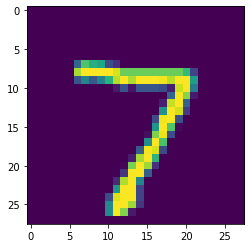

In [ ]:
plt.imshow(images[0])

In [ ]:
teacher1 = torch.load("teacher0to6.pt")
teacher1.to("cuda")
teacher2 = torch.load("teacher3to9.pt")
teacher2.to("cuda")

Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden1): Linear(in_features=784, out_features=1200, bias=True)
  (hidden1_dropout): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=1200, out_features=1200, bias=True)
  (hidden2_dropout): Dropout(p=0.5, inplace=False)
  (hidden3): Linear(in_features=1200, out_features=7, bias=True)
)

In [ ]:
img1 = images[2].to("cuda") #1
img2 = images[4].to("cuda") #4
img3 = images[0].to("cuda") #7

In [ ]:
teacher2(img2.reshape(1, 784).float())

tensor([[-11.6992,  17.8440, -11.1168,  -0.3323,   4.5431,  -1.7922,   8.2899]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
z1_1 = teacher1(img1.reshape(1, 784).float()) #logits teacher1 per num 1
z1_2 = teacher2(img1.reshape(1, 784).float()) #logits teacher2 per num 1

z2_1 = teacher1(img2.reshape(1, 784).float()) #logits teacher1 per num 4
z2_2 = teacher2(img2.reshape(1, 784).float()) #logits teacher2 per num 4

z3_1 = teacher1(img3.reshape(1, 784).float()) #logits teacher1 per num 7
z3_2 = teacher2(img3.reshape(1, 784).float()) #logits teacher2 per num 7

In [ ]:
m = nn.Softmax(dim=1)

probs_t1 = m(z3_1)
probs_t2 = m(z3_2)

probs_t1 = probs_t1.cpu().data.numpy()
probs_t2 = probs_t2.cpu().data.numpy()

In [ ]:
dict_probs_t1 = {}
dict_probs_t2 = {}

for idx in range(7):
    dict_probs_t1[idx] = probs_t1[0][idx]

for idx in range(3, 10):
    dict_probs_t2[idx] = probs_t2[0][idx - 3]

print(dict_probs_t1)
print(dict_probs_t2)

{0: 0.0101718595, 1: 2.157596e-05, 2: 0.53603435, 3: 0.4334892, 4: 0.0017076073, 5: 0.01857305, 6: 2.345939e-06}
{3: 2.776103e-07, 4: 4.216657e-11, 5: 9.1008195e-10, 6: 2.3212262e-19, 7: 0.9999994, 8: 9.484371e-10, 9: 3.7950514e-07}


In [ ]:
def grad_j(dict_probs_t1, dict_probs_t2, u):
    grad_j = np.random.rand(10)
    for i,u_i in enumerate(u):
        dui = 0
        if i in dict_probs_t1.keys():
            dui = dui - dict_probs_t1[i]
            e = np.exp(u_i)/np.sum(np.exp(list(dict_probs_t1.values())))
            dui = dui + np.sum(np.array(list(dict_probs_t1.values()))*e)
        if i in dict_probs_t2.keys():
            dui = dui - dict_probs_t2[i]
            e = np.exp(u_i)/np.sum(np.exp(list(dict_probs_t2.values())))
            dui = dui + np.sum(np.array(list(dict_probs_t2.values()))*e)
        grad_j[i] = dui
    return grad_j
    
u = np.random.rand(10)
for it in range(100):
    u = u - 0.1 * grad_j(dict_probs_t1, dict_probs_t2, u)

def compute_q(dict)

print(u)

[-0.72046277 -0.79381421  1.47618259  0.60033151 -1.20343489 -1.09552558
 -1.21452235  2.16519081 -0.76612846 -0.76612568]


In [ ]:
def grad_j(dict_probs_t1, dict_probs_t2, u):
    grad_j = np.random.rand(10)
    for i,u_i in enumerate(u):
        dui = 0
        if i in dict_probs_t1.keys():
            dui = dui - dict_probs_t1[i]
            e = np.exp(u_i)/np.sum(np.exp(list(dict_probs_t1.values())))
            dui = dui + np.sum(np.array(list(dict_probs_t1.values()))*e)
        if i in dict_probs_t2.keys():
            dui = dui - dict_probs_t2[i]
            e = np.exp(u_i)/np.sum(np.exp(list(dict_probs_t2.values())))
            dui = dui + np.sum(np.array(list(dict_probs_t2.values()))*e)
        grad_j[i] = dui
    return grad_j


iters = 100
m = nn.Softmax(dim=1)
m2 = nn.Softmax()
q2 = torch.rand([images_train.shape[0],10])

for i in range(images_train.shape[0])[:10]:
    # Obtain image
    img = images_train[i].to("cuda")
    
    # Obtain logits from teacher
    z1 = teacher1(img.reshape(1, 784).float())
    z2 = teacher2(img.reshape(1, 784).float())
    
    # compute softmax to obtain p_i
    probs_t1 = m(z1).cpu().data.numpy()[0] 
    probs_t2 = m(z2).cpu().data.numpy()[0]
    print(probs_t1)
    print(probs_t2)

    dict_probs_t1 = {idx:probs_t1[idx] for idx in range(7)}
    dict_probs_t2 = {idx:probs_t2[idx-3] for idx in range(3, 10)}

    # compute gradient descent
    u = np.random.rand(10)
    for it in range(iters):
        u = u - 0.1 * grad_j(dict_probs_t1, dict_probs_t2, u)
    
    # compute softmax to obtain q
    q2[i] = m2(torch.from_numpy(u))
    if i%100==0: print(f'Computing q of image: {i}')
    print(q2[i])
    print()


[8.7859308e-07 4.1704817e-07 2.3125999e-06 4.8301388e-02 1.6423806e-07
 9.5168871e-01 6.0112498e-06]
[7.9523915e-01 5.4650513e-16 2.0391746e-01 3.5566090e-17 1.2459070e-08
 2.6144001e-08 8.4336201e-04]
Computing q of image: 0
tensor([0.0389, 0.0389, 0.0389, 0.3028, 0.0251, 0.4149, 0.0251, 0.0384, 0.0384,
        0.0387])

[1.0000000e+00 4.4699798e-21 1.4657111e-13 9.1459322e-17 8.8119887e-15
 3.1025978e-16 3.0977543e-09]
[0.10898796 0.02977746 0.0897084  0.5497459  0.02682933 0.08194578
 0.11300517]
tensor([0.5565, 0.0297, 0.0297, 0.0359, 0.0228, 0.0323, 0.1477, 0.0348, 0.0501,
        0.0606])

[9.5134549e-09 8.5265361e-13 2.3735411e-06 1.9420778e-08 9.9999762e-01
 2.7389408e-12 9.3391780e-11]
[4.1900779e-07 9.8747987e-01 2.6866273e-06 2.3296420e-07 4.6015231e-04
 2.9171244e-04 1.1764901e-02]
tensor([0.0375, 0.0375, 0.0375, 0.0244, 0.6984, 0.0244, 0.0244, 0.0376, 0.0375,
        0.0408])

[8.1788194e-14 1.0000000e+00 2.5015480e-12 1.8737793e-13 8.9008037e-12
 7.3944872e-14 2.8208330e-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0.0228, 0.4267, 0.0228, 0.0150, 0.0148, 0.0153, 0.0148, 0.0228, 0.4221,
        0.0229])

[6.3758308e-26 6.1798101e-18 3.9375237e-15 1.0000000e+00 1.4642666e-24
 2.6012228e-16 1.8982915e-35]
[9.9996924e-01 1.4776839e-15 1.4766550e-12 3.3818189e-23 8.3293088e-09
 3.9637993e-07 3.0426860e-05]
tensor([0.0374, 0.0374, 0.0374, 0.7023, 0.0244, 0.0244, 0.0244, 0.0374, 0.0374,
        0.0375])

[2.0531465e-19 1.0000000e+00 6.5970235e-17 1.6741420e-15 2.9234698e-11
 4.7663080e-17 3.4294825e-17]
[0.01409361 0.20498638 0.55737245 0.00415134 0.0334498  0.1435456
 0.04240084]
tensor([0.0294, 0.5512, 0.0294, 0.0205, 0.0558, 0.1485, 0.0192, 0.0361, 0.0716,
        0.0384])

[2.4268029e-28 2.7643161e-28 1.1559910e-16 1.4410366e-25 1.0000000e+00
 1.1951029e-26 7.4900868e-30]
[4.3751496e-15 1.0000000e+00 4.7351896e-14 2.1987448e-13 1.0115954e-10
 1.3392108e-14 4.4576058e-11]
tensor([0.0374, 0.0374, 0.0374, 0.0244, 0.7023, 0.0244, 0.0244, 0.0374, 0.0374,
        0.0374])



In [ ]:
for i in range(10):
    print()
    print(q2[i])

tensor([0.0376, 0.0376, 0.0402, 0.0270, 0.0245, 0.6956, 0.0247, 0.0377, 0.0377,
        0.0377])
tensor([0.5448, 0.0291, 0.0291, 0.0187, 0.0294, 0.0202, 0.1971, 0.0286, 0.0422,
        0.0610])
tensor([0.0375, 0.0375, 0.0375, 0.0244, 0.7004, 0.0244, 0.0244, 0.0375, 0.0375,
        0.0391])
tensor([0.0255, 0.4780, 0.0255, 0.0508, 0.0239, 0.0168, 0.0192, 0.3081, 0.0254,
        0.0267])
tensor([0.0287, 0.0287, 0.0287, 0.0289, 0.2481, 0.0194, 0.0187, 0.0289, 0.0289,
        0.5413])
tensor([0.0247, 0.0247, 0.4634, 0.0429, 0.0160, 0.0162, 0.0159, 0.3365, 0.0328,
        0.0269])
tensor([0.0292, 0.5472, 0.0292, 0.1307, 0.0431, 0.0190, 0.0186, 0.0698, 0.0529,
        0.0605])
tensor([0.0374, 0.0374, 0.0374, 0.7023, 0.0244, 0.0244, 0.0244, 0.0374, 0.0374,
        0.0374])
tensor([0.0279, 0.5233, 0.0279, 0.0192, 0.0669, 0.0302, 0.0202, 0.1421, 0.0525,
        0.0898])
tensor([0.0374, 0.0374, 0.0374, 0.0244, 0.7023, 0.0244, 0.0244, 0.0374, 0.0374,
        0.0374])


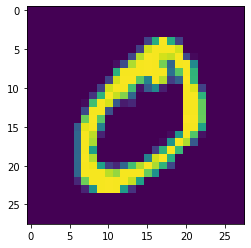

In [ ]:
plt.imshow(images_train[1]);

In [ ]:
for i,p in enumerate(q[1]):
    print(f'{i}: {p}')

0: 0.4780184030532837
1: 0.025491097941994667
2: 0.025491097941994667
3: 0.01655544899404049
4: 0.01968778483569622
5: 0.022822504863142967
6: 0.0297218170017004
7: 0.04491875320672989
8: 0.038451991975307465
9: 0.29884108901023865


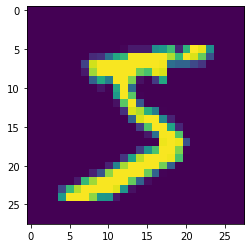

In [ ]:
plt.imshow(images_train[0]);

In [ ]:
for i,p in enumerate(q[0]):
    print(f'{i}: {p}')

0: 0.03744512051343918
1: 0.03744512051343918
2: 0.03744512051343918
3: 0.024399463087320328
4: 0.02435402385890484
5: 0.7022225260734558
6: 0.02435402385890484
7: 0.03744395449757576
8: 0.03744395449757576
9: 0.03744671121239662


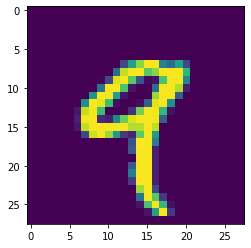

In [ ]:
plt.imshow(images_train[4]);

In [ ]:
for i,p in enumerate(q[4]):
    print(f'{i}: {p}')

0: 0.028607642278075218
1: 0.028629299253225327
2: 0.029097916558384895
3: 0.020536988973617554
4: 0.2602550983428955
5: 0.01986829936504364
6: 0.018598005175590515
7: 0.028652815148234367
8: 0.028647642582654953
9: 0.5371063351631165


In [ ]:
q

tensor([[0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
        [0.4780, 0.0255, 0.0255,  ..., 0.0449, 0.0385, 0.2988],
        [0.0376, 0.0376, 0.0376,  ..., 0.0393, 0.0375, 0.0428],
        ...,
        [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
        [0.0375, 0.0375, 0.0375,  ..., 0.0375, 0.0375, 0.0375],
        [0.2370, 0.0256, 0.0269,  ..., 0.0263, 0.4938, 0.0263]])

In [ ]:
def student_loss(outputs, labels, teacher_outputs, alpha, temperature):

    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [ ]:
# Setup model and move it to the GPU
device = 'cuda'
student = Model(n_classes=7, hidden_size=800, dropout=0.2, hidden_dropout=0.5)
student.to(device)

learning_rate = 0.001

# Set up loss function and optimizer
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

# Run over 1000 epochs (1 epoch = visited all items in dataset)
for epoch in range(500):
    running_loss = 0.0
    total = 0

    for data in trainloader:
        # Apply the learning rate decay
        if(epoch % 100 == 0 and epoch != 0):
            learning_rate = learning_rate * 0.5
            optimizer = optim.SGD(student.parameters(), lr= learning_rate, momentum=0.9)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = labels.to(device).long()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Set temperature and the weights for losses linear combination
        w = 0.7
        T = 20

        # Compute soft labels using deep teacher model previously trained
        outputs_teacher = teacher0to6(inputs.float())

        # Student forward + backward + optimize
        outputs_stud = student(inputs.float())
        
        loss = student_loss(outputs_stud, target, outputs_teacher, w, T)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')